Final Project Submission

* Student name: Susanna Han
* Student pace: part time
* Scheduled project review date/time: 07/05/2020
* Instructor name: James Irving
* Blog post URL: 

# Introduction

We are building a model that can rate the sentiment of a tweet based on its content. The tweet reviews are on the following products and services.


- IPhone
- Ipad
- Apple Apps (Iphone/Ipad)
- Other Apple product or service 


- Google
- Android
- Android Apps
- Other Google product or service 


Using a Natural Language Processing model allows us to analyze text data, which makes analyzing the score of the 9,093 product tweets possible. Finding the correlation and important features of the positive and negative feedback helps provide insight to the products and services being reviewed. 


The data set we used has three columns which includes the tweet (the review), which product the review is referring to, and whether or not the review was positive, negative, or neutral. 



Below are all libraries and programs used in building our models:

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from ipywidgets import interact
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/susannahan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Functions:

In [2]:
def evaluate_model(y_test,y_pred,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                   figsize = (10,4),
                   display_labels=('Negative','Neutral','Positive')):
    """
    Arguments needed to evaluate the model are y_test, y_pred, x_test, 
    the model, and display labels.
    
    Evaluate_model prints out the precision, recall, and f1-score score. As well as accuracy, 
    macro average, and weighted average.
    
    Below, a Confusion Matrix visual shows the percentage of how accurate the model fit both predicted and actual
    values. 
    
    """
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))
    # plots Confusion Matrix
    metrics.plot_confusion_matrix(clf,X_test,y_test,cmap="Blues",
                                  normalize='true', 
                                  display_labels = display_labels)
    #plt.title('Confusion Matrix')
    plt.show()

    try: 
        df_important = plot_importance(clf)
    except:
        df_important = None
        

In [3]:
def plot_importance(tree_clf, top_n=20,figsize=(10,8)):
    """ Arguments needed to plot an importance bar graph is the model, number of features to display, and 
    desired figsize for the graph. 
    
    This function displays a bar graph of top 20 important features from most to least important."""
    
    #calculates which feature was used the most in the model.
    df_importance = pd.Series(tree_clf.feature_importances_,vectorizer.get_feature_names())
    
    #sorts 20 important features data in ascending order
    df_importance.sort_values().tail(20).plot(
        kind='barh', figsize=figsize)

    #graph labels
    
    #plt.title('Top Important Features')
    plt.xlabel('Features Importance')
    plt.ylabel('Features')


    plt.show() 

    return df_importance

# Observations

First, we import the data and look through the dataset and make observations of what to change in the dataset to build a good model.

In [4]:
df = pd.DataFrame(pd.read_csv('tweets.csv', encoding = 'unicode_escape'))
#importing the dataset

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


One of the first observations we see is that the column names are very long and make it more difficult to recall and work with. Therefore, they were modified and renamed to tweets, product, and emotion as shown below.

In [6]:
df.rename(columns = {'tweet_text':'tweets', 'emotion_in_tweet_is_directed_at': 'product', 
              'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweets   9092 non-null   object
 1   product  3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
df.shape
#shows the shape of our dataframe - 9093 rows and 3 columns.

(9093, 3)

### Finding missing values.

In [9]:
print (f'Product Missing Values:', df['product'].isna().sum())
# 5802 out of 9093 rows are missing product. 
print ('Tweets Missing Values:',df['tweets'].isna().sum())
print ('Emotion Missing Values:',df['emotion'].isna().sum())

Product Missing Values: 5802
Tweets Missing Values: 1
Emotion Missing Values: 0


We have decided to keep all missing values in the product column to add more data to the correlation between tweet and emotion. The one missing row from the tweets column is dropped because it adds no value to the dataset.

In [10]:
df['tweets'].dropna(inplace=True)

In [11]:
df['tweets'].isna().sum()

0

Now that we have taken care of the missing values we look into all the categories in each columns. In the "emotion" column we see that there are 4 categories and the " I can't tell " category only having 1% of the data. Therefore, dropping that category as it does not provide much information needed and is only a small portion of the dataset. 

In [12]:
df['emotion'].value_counts(normalize=True)
#shows percentage of each value in column. 
#neutral - 59%
#positive - 33%
#negative - 6%
#unknown - 2%

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [13]:
#drop I can't tell from column 'emotion'
df.drop(df.loc[df['emotion']=="I can't tell"].index, inplace=True)

### Data Distribution

In [14]:
df['emotion'].value_counts()
#All "I can't tell" rows has successfully been dropped from the column.

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

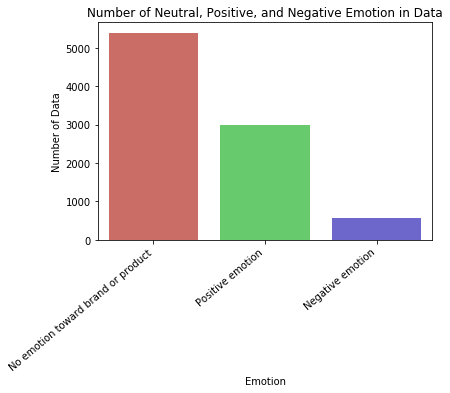

In [15]:
y= df["emotion"].value_counts()
ax = sns.barplot(y.index, y.values, palette="hls")
ax.set_title('Number of Neutral, Positive, and Negative Emotion in Data')
ax.set(xlabel='Emotion', ylabel='Number of Data')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show();

We are able to see the imbalance in our dataset as there are many more neutral tweets than there are positive and negative. Therefor we are going to separate the data into it's individual dataset to extract information from what is given.

# Processing Data

After cleaning out the dataset we started to clean the text in the tweets column to properly train the model to process the given text. We use word_tokenize to separate each word and punctuation to more accurately get rid of empty spaces/words when using stopwords. 

In [16]:
corpus = df['tweets']

In [17]:
corpus[:10]

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
5    @teachntech00 New iPad Apps For #SpeechTherapy...
6                                                  NaN
7    #SXSW is just starting, #CTIA is around the co...
8    Beautifully smart and simple idea RT @madebyma...
9    Counting down the days to #sxsw plus strong Ca...
Name: tweets, dtype: object

## Stop Words List

Stopwords is a list of common words that do not add meaning to a sentence. Bigrams identifies words in pairs which helps in finding sentiment analysis. We created a list of stopwords to apply to the tokenized text for each category. A 'more_punc' list was created to add to the stopwords list that were common in the data texts that didn't add any value.

In [18]:
stopwords_list = stopwords.words('english')

more_punc = ['--',"'",'...','\\','.','%',',','sxsw','link','mention','rt','austin',
            'rise_austin','link','{','}','-','&',';','iphone','apple','ipad',
            'quot','also','marissa','google','app','#sxsw', '@mention']

stopwords_list+=string.punctuation
stopwords_list.extend(more_punc)

### Positive Emotion Data

In [19]:
positive_df = df.loc[df['emotion']=="Positive emotion"]

In [20]:
positive_df[:5]

,tweets,product,emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion


In [21]:
pos_corpus = positive_df['tweets'].head()

In [22]:
pos_corpus[:10]

1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
7    #SXSW is just starting, #CTIA is around the co...
8    Beautifully smart and simple idea RT @madebyma...
Name: tweets, dtype: object

In [23]:
string = ','.join(str(v) for v in pos_corpus)
patterns = [r"(http?://\w*\.\w*/+\w+)",
            r'\#\w*',
            r'RT [@]?\w*:',
            r'\@\w*',
            r"(?=\S*['-])([a-zA-Z'-]+)"]
            
clean_pos_corpus = re.sub('|'.join(patterns), '', string)

In [24]:
clean_pos_corpus

' Know about  ? Awesome iPad/iPhone app that  likely appreciate for its design. Also,  giving free Ts at , Can not wait for  2 also. They should sale them down at ., great stuff on Fri : Marissa Mayer (Google), Tim  (tech books/conferences) &amp; Matt Mullenweg (Wordpress), is just starting,  is around the corner and  is only a hop skip and a jump from there, good time to be an  fan,Beautifully smart and simple idea RT   wrote about our  iPad app for ! '

In [25]:
pos_tokens = nltk.word_tokenize(clean_pos_corpus)

In [26]:
pos_tokens[:10]

['Know',
 'about',
 '?',
 'Awesome',
 'iPad/iPhone',
 'app',
 'that',
 'likely',
 'appreciate',
 'for']

In [27]:
pos_tokenized = [word.lower() for word in pos_tokens if word.lower() not in stopwords_list]

In [28]:
pos_tokenized[:10]

['know',
 'awesome',
 'ipad/iphone',
 'likely',
 'appreciate',
 'design',
 'giving',
 'free',
 'ts',
 'wait']

In [29]:
pos_freq = FreqDist(pos_tokenized)
pos_freq.most_common(10)

[('know', 1),
 ('awesome', 1),
 ('ipad/iphone', 1),
 ('likely', 1),
 ('appreciate', 1),
 ('design', 1),
 ('giving', 1),
 ('free', 1),
 ('ts', 1),
 ('wait', 1)]

In [30]:
list(nltk.bigrams(pos_tokenized[:10]))

[('know', 'awesome'),
 ('awesome', 'ipad/iphone'),
 ('ipad/iphone', 'likely'),
 ('likely', 'appreciate'),
 ('appreciate', 'design'),
 ('design', 'giving'),
 ('giving', 'free'),
 ('free', 'ts'),
 ('ts', 'wait')]

### Negative Emotion Data

In [31]:
negative_df = df.loc[df['emotion']=="Negative emotion"]

In [32]:
negative_df[:5]

,tweets,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
38,@mention - False Alarm: Google Circles Not Co...,Google,Negative emotion
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion


In [33]:
neg_corpus = negative_df['tweets']

In [34]:
neg_corpus[:10]

0      .@wesley83 I have a 3G iPhone. After 3 hrs twe...
3      @sxsw I hope this year's festival isn't as cra...
17     I just noticed DST is coming this weekend. How...
38     @mention  - False Alarm: Google Circles Not Co...
64     Again? RT @mention Line at the Apple store is ...
67     attending @mention iPad design headaches #sxsw...
68     Boooo! RT @mention Flipboard is developing an ...
92     What !?!? @mention  #SXSW does not provide iPh...
103    Know that &quot;dataviz&quot; translates to &q...
170    Seriously #sxsw? Did you do any testing on the...
Name: tweets, dtype: object

In [35]:
string = ','.join(str(v) for v in neg_corpus)
patterns = [r"(http?://\w*\.\w*/+\w+)",
            r'\#\w*',
            r'RT [@]?\w*:',
            r'\@\w*',
            r"(?=\S*['-])([a-zA-Z'-]+)"]
clean_neg_corpus = re.sub('|'.join(patterns), '', string)

In [36]:
clean_neg_corpus

'. I have a 3G iPhone. After 3 hrs tweeting at , it was dead!  I need to upgrade. Plugin stations at ., I hope this  festival  as crashy as this  iPhone app. ,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning?  ,   False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever?  {link}    ,Again? RT  Line at the Apple store is insane.. ,attending  iPad design headaches  {link},Boooo! RT  Flipboard is developing an iPhone version, not Android, says  ,What !?!?    does not provide iPhone chargers?!?   changed my mind about going next year!,Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone.  just . ,Seriously ? Did you do any testing on the mobile apps? Constant iPad crashes causing lost schedules, and no sync for WP7.,ipad2 and ...a conflagration of doofusness.  {link},You spent $1,000+ to come to SXSW. \n\n already used iPad 1. \n\nThe wait is a couple city blocks. \n\nWhy?   {}, up to 2 iP

In [37]:
neg_tokens = nltk.word_tokenize(clean_neg_corpus)

In [38]:
neg_tokenized = [word.lower() for word in neg_tokens if word.lower() not in stopwords_list]

In [39]:
neg_tokenized

['3g',
 '3',
 'hrs',
 'tweeting',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'hope',
 'festival',
 'crashy',
 'noticed',
 'dst',
 'coming',
 'weekend',
 'many',
 'users',
 'hour',
 'late',
 'come',
 'sunday',
 'morning',
 'false',
 'alarm',
 'circles',
 'coming',
 'now\x89ûòand',
 'probably',
 'ever',
 'line',
 'store',
 'insane..',
 'attending',
 'design',
 'headaches',
 'boooo',
 'flipboard',
 'developing',
 'version',
 'android',
 'says',
 'provide',
 'chargers',
 'changed',
 'mind',
 'going',
 'next',
 'year',
 'know',
 'dataviz',
 'translates',
 'satanic',
 'seriously',
 'testing',
 'mobile',
 'apps',
 'constant',
 'crashes',
 'causing',
 'lost',
 'schedules',
 'sync',
 'wp7.',
 'ipad2',
 'conflagration',
 'doofusness',
 'spent',
 '1,000+',
 'come',
 'already',
 'used',
 '1',
 'wait',
 'couple',
 'city',
 'blocks',
 '2',
 '2s',
 'seen',
 'wild',
 'people',
 'say',
 'fast',
 'still',
 'pics',
 'terrible',
 'alarms',
 'botch',
 'timechange',
 'many',
 'freak',
 'late',
 

In [40]:
neg_freq = FreqDist(neg_tokenized)
neg_freq.most_common(10)

[('2', 61),
 ('store', 44),
 ('new', 43),
 ('like', 39),
 ('design', 28),
 ('social', 28),
 ('people', 27),
 ('circles', 26),
 ('apps', 26),
 ('need', 25)]

In [41]:
list(nltk.bigrams(neg_tokenized[:10]))

[('3g', '3'),
 ('3', 'hrs'),
 ('hrs', 'tweeting'),
 ('tweeting', 'dead'),
 ('dead', 'need'),
 ('need', 'upgrade'),
 ('upgrade', 'plugin'),
 ('plugin', 'stations'),
 ('stations', 'hope')]

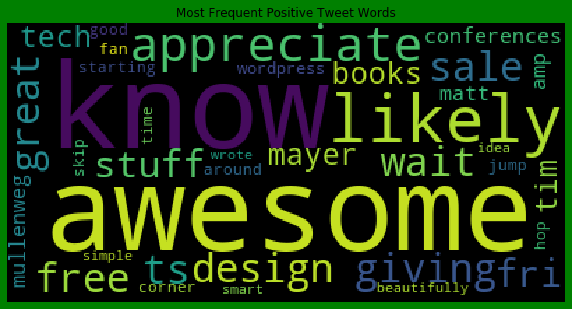

In [42]:
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(pos_tokenized))
plt.figure(figsize = (10, 12), facecolor = 'green', edgecolor = 'green') 
plt.imshow(wordcloud) 
plt.title('Most Frequent Positive Tweet Words')
plt.axis('off');

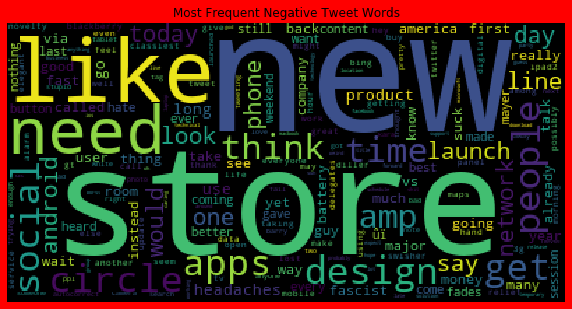

In [43]:
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(neg_tokenized))
plt.figure(figsize = (10, 12), facecolor = 'red', edgecolor = 'red') 
plt.imshow(wordcloud) 
plt.title('Most Frequent Negative Tweet Words')
plt.axis('off');

Then we figured out the frequency distribution for all the stopped_tokens as well as the bigrams to see the top most common words used in the text.

Regular Expressions is then used to remove or highlight any URLs, hashtags, retweets, and metions that can be misunderstood when being ran through the model. The block of code below gathers all the URLS, hashtags, retweets, and mentions to have a glance at what's in our data.

In the code below we are able to find the URLs, hashtags, retweets, and mentions individually on any row. 

Now that our data is cleaned we are able to pre-process the data with the function below. It goes through the steps of finding all the urls, retweets, and hastags and replacing it with spaces, then Lemmatizing the text if necessary. Lemmatization is used to convert the different tenses into the same root word to mean the same thing.As well as detecting and getting rid of the pattern. If the text does not qualify for the adjustments it outputs the tokenized text.  

A target column was created that indicated the tweet expressed a Positive emotion. Another column was created for tweets that had no emotion toward brand or product.

In [44]:
#add a target column where the emotion toward the product is positive. 
df['target'] = (df['emotion'] == 'Positive emotion').astype(int)
df['negative'] = (df['emotion'] == 'Negative emotion').astype(int)
df['neutral'] = (df['emotion'] == 'No emotion toward brand or product').astype(int)
df.head()

,tweets,product,emotion,target,negative,neutral
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1,0,0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1,0,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1,0,0


# Model 1


In [45]:
y = df['emotion'].copy()
X = df['tweets'].copy()

In [46]:
X_train,X_test, y_train,y_test = train_test_split(X,y,stratify=y,random_state=45)

We can see that the data was evenly distributed between both the train and test sets. 

In [47]:
y_train.value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333184
Negative emotion                      0.063862
Name: emotion, dtype: float64

In [48]:
y_test.value_counts(normalize=True)

No emotion toward brand or product    0.603132
Positive emotion                      0.333333
Negative emotion                      0.063535
Name: emotion, dtype: float64

In [49]:
X_train.isna().sum()

1

In [50]:
X_train.fillna('',inplace=True)

In [51]:
X_train.isna().sum()

0

In [52]:
string = ','.join(str(v) for v in corpus)
patterns = [r"(http?://\w*\.\w*/+\w+)",
            r'\#\w*',
            r'RT [@]?\w*:',
            r'\@\w*',
            r"(?=\S*['-])([a-zA-Z'-]+)"]
            
clean_corpus = re.sub('|'.join(patterns), '', string)

In [53]:
tokenizer = nltk.tokenize.word_tokenize(clean_corpus)

In [54]:
tokenized = [word.lower() for word in tokenizer if word.lower() not in stopwords_list]

In [55]:
vectorizer = TfidfVectorizer(tokenized,stop_words=stopwords_list)
vectorizer

TfidfVectorizer(input=['3g', '3', 'hrs', 'tweeting', 'dead', 'need', 'upgrade',
                       'plugin', 'stations', 'know', 'awesome', 'ipad/iphone',
                       'likely', 'appreciate', 'design', 'giving', 'free', 'ts',
                       'wait', '2', 'sale', 'hope', 'festival', 'crashy',
                       'great', 'stuff', 'fri', 'mayer', 'tim', 'tech', ...],
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [56]:
X_train_tfidf = vectorizer.fit_transform(X_train).astype(float)
X_test_tfidf = vectorizer.transform(X_test).astype(float)

In [57]:
X_train_tfidf.shape
#(tweets, words)

(6702, 8325)

In [58]:
## Make, fit model
base_tree = RandomForestClassifier(class_weight='balanced')
base_tree.fit(X_train_tfidf,y_train)

RandomForestClassifier(class_weight='balanced')

In [59]:
## Get predictions
y_hat_train = base_tree.predict(X_train_tfidf)
y_hat_test =  base_tree.predict(X_test_tfidf)

                                    precision    recall  f1-score   support

                  Negative emotion       0.73      0.21      0.33       142
No emotion toward brand or product       0.71      0.86      0.78      1348
                  Positive emotion       0.64      0.49      0.56       745

                          accuracy                           0.69      2235
                         macro avg       0.69      0.52      0.55      2235
                      weighted avg       0.69      0.69      0.68      2235



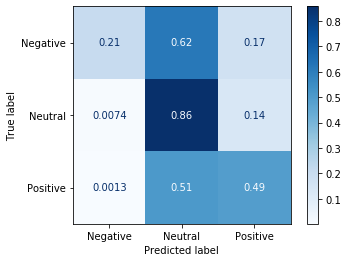

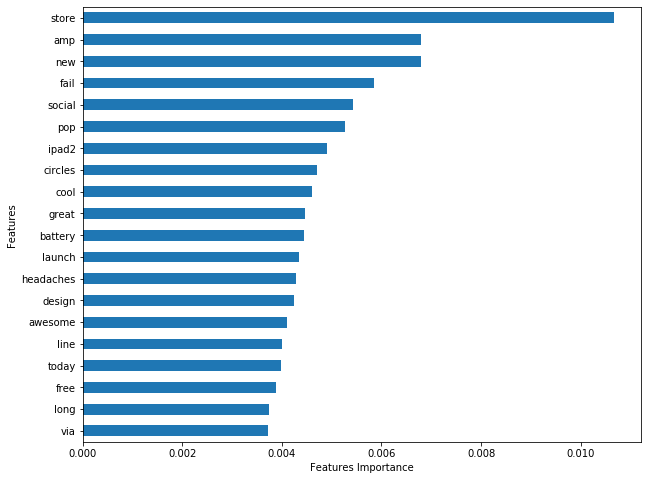

In [60]:
evaluate_model(y_test, y_hat_test, X_test_tfidf, base_tree) 

In [61]:
display(base_tree.score(X_train_tfidf, y_train))
display(base_tree.score(X_test_tfidf, y_test))

0.957624589674724

0.694407158836689

The base model has an accuracy of 70%

# Model 2

In [62]:
y = df['emotion'].copy()
X = df['tweets'].copy()

In [63]:
X_train,X_test, y_train,y_test = train_test_split(X,y,stratify=y,random_state=45)

In [64]:
y_train.value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333184
Negative emotion                      0.063862
Name: emotion, dtype: float64

In [65]:
y_test.value_counts(normalize=True)

No emotion toward brand or product    0.603132
Positive emotion                      0.333333
Negative emotion                      0.063535
Name: emotion, dtype: float64

In [66]:
X_train.fillna('',inplace=True)
X_train.isna().sum()

0

In [67]:
tokenizer = nltk.tokenize.word_tokenize(clean_corpus)

In [68]:
tokenized = [word.lower() for word in tokenizer if word.lower() not in stopwords_list]

In [69]:
vectorizer = TfidfVectorizer(tokenized,stop_words=stopwords_list, binary=True)
vectorizer

TfidfVectorizer(binary=True,
                input=['3g', '3', 'hrs', 'tweeting', 'dead', 'need', 'upgrade',
                       'plugin', 'stations', 'know', 'awesome', 'ipad/iphone',
                       'likely', 'appreciate', 'design', 'giving', 'free', 'ts',
                       'wait', '2', 'sale', 'hope', 'festival', 'crashy',
                       'great', 'stuff', 'fri', 'mayer', 'tim', 'tech', ...],
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [70]:
X_train_tfidf = vectorizer.fit_transform(X_train).astype(float)
X_test_tfidf = vectorizer.transform(X_test).astype(float)

In [71]:
best_tree = RandomForestClassifier(class_weight='balanced')
best_tree.fit(X_train_tfidf,y_train)

RandomForestClassifier(class_weight='balanced')

In [72]:
rf_random = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': ['gini','entropy']}

In [73]:
rf_tree = RandomizedSearchCV(estimator = rf_random, 
                             param_distributions = random_grid, 
                             n_iter = 100,cv = 3, verbose=2, 
                             random_state=45, n_jobs = -1)

In [74]:
rf_tree.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 112, 175, 237,
                                                         300]},
                   random_state=45, verbose=2)

In [75]:
display(rf_tree.best_params_)

{'n_estimators': 112,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [76]:
tree_2 = rf_tree.best_estimator_
#tree with best params
y_hat_test = tree_2.predict(X_test_tfidf)
#predictions

                                    precision    recall  f1-score   support

                  Negative emotion       0.74      0.12      0.21       142
No emotion toward brand or product       0.70      0.91      0.79      1348
                  Positive emotion       0.69      0.44      0.54       745

                          accuracy                           0.70      2235
                         macro avg       0.71      0.49      0.51      2235
                      weighted avg       0.70      0.70      0.67      2235



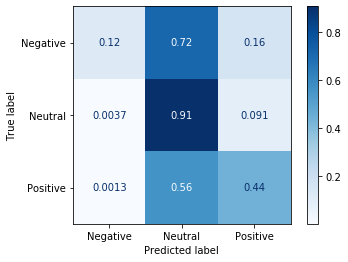

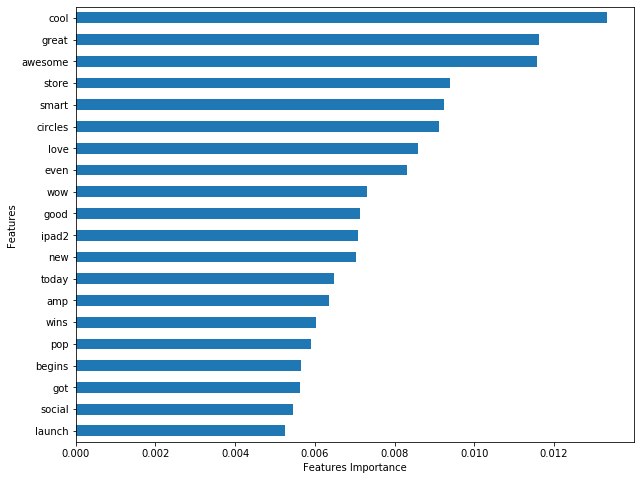

In [77]:
evaluate_model(y_test, y_hat_test, X_test_tfidf, tree_2)

In [78]:
display(tree_2.score(X_train_tfidf, y_train))
display(tree_2.score(X_test_tfidf, y_test))

0.8646672635034318

0.7002237136465325

The best model has an accuracy of 71%

# Results

# Conclusion and Recommendations